# Learning low-dimensional patient representations using AutoEncoder

Data: Critically ill patients in MIMIC-III

In [1]:
# Remove all warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data set into DataFrame
import pandas as pd
import numpy as np

data = pd.read_csv('data/in_hospital_mortality_48_hour_chunk_6.csv', 
                  header = 0)

In [3]:
data.shape

(17903, 674)

Number of cases:  2423
Number of controls :  15480

Proportion of case: 13.53%


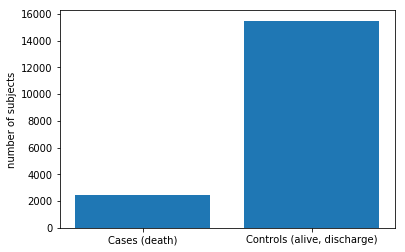

In [59]:
# Explore the number of cases (death) and controls (alive finally) 

n_case = len(data[data['label'] == 1])
n_control = len(data[data['label'] == 0]) 

print('Number of cases: ', n_case) 
print('Number of controls : ', n_control)
print()
print('Proportion of case: %.2f%%' % (100 * n_case / (n_control + n_case)))


# Visualize case-control distribution

import matplotlib.pyplot as plt
plt.bar(['Cases (death)','Controls (alive, discharge)'], [n_case, n_control]) 

plt.ylabel('number of subjects')

plt.show()

In [5]:
# Evaluate missing values
print(data.isnull().sum() / len(data))

Subj                                  0.000000
Capillary refill rate_0_6_max         0.991175
Diastolic blood pressure_0_6_max      0.032062
Fraction inspired oxygen_0_6_max      0.763838
Glascow coma scale total_0_6_max      0.458582
                                        ...   
Systolic blood pressure_42_48_skew    0.021002
Temperature_42_48_skew                0.065017
Weight_42_48_skew                     0.883148
pH_42_48_skew                         0.715187
label                                 0.000000
Length: 674, dtype: float64


In [6]:
# Explore data distribution

data.drop(columns = ['label']).describe()

,Capillary refill rate_0_6_max,Diastolic blood pressure_0_6_max,Fraction inspired oxygen_0_6_max,Glascow coma scale total_0_6_max,Glucose_0_6_max,Heart Rate_0_6_max,Height_0_6_max,Mean blood pressure_0_6_max,Oxygen saturation_0_6_max,Respiratory rate_0_6_max,...,Glucose_42_48_skew,Heart Rate_42_48_skew,Height_42_48_skew,Mean blood pressure_42_48_skew,Oxygen saturation_42_48_skew,Respiratory rate_42_48_skew,Systolic blood pressure_42_48_skew,Temperature_42_48_skew,Weight_42_48_skew,pH_42_48_skew
count,158.000000,17329.000000,4228.000000,9693.000000,14859.000000,17328.000000,1954.000000,17312.000000,17430.000000,1.729400e+04,...,12566.000000,17542.000000,186.0,17476.000000,17377.000000,17421.000000,17527.000000,16739.000000,2092.000000,5099.000000
mean,0.227848,89.944947,0.762594,11.235221,176.647890,97.773777,168.357728,96.209777,99.107263,1.603812e+02,...,0.018496,0.164419,0.0,0.122570,-0.337341,0.076805,0.032787,0.000338,0.002711,-0.024231
std,0.420778,1156.785889,0.255512,4.163617,134.846511,22.766559,16.346462,53.586899,6.682211,1.791189e+04,...,0.273092,0.699109,0.0,0.705537,0.845839,0.798692,0.658855,0.249274,0.105190,0.264073
min,0.000000,25.000000,0.000000,3.000000,35.000000,33.000000,0.000000,31.000000,43.000000,0.000000e+00,...,-1.933405,-2.855201,0.0,-2.514505,-6.851991,-4.364358,-2.892597,-2.842783,-2.041241,-2.041241
25%,0.000000,64.000000,0.500000,8.000000,120.000000,83.000000,160.000000,82.000000,99.000000,1.900000e+01,...,0.000000,-0.283633,0.0,-0.336710,-0.795495,-0.381802,-0.406019,0.000000,0.000000,0.000000
50%,0.000000,74.000000,0.950000,13.000000,152.000000,95.000000,170.000000,92.000000,100.000000,2.300000e+01,...,0.000000,0.134020,0.0,0.084401,-0.213454,0.030105,0.001134,0.000000,0.000000,0.000000
75%,0.000000,85.000000,1.000000,15.000000,195.000000,111.000000,178.000000,105.000000,100.000000,2.800000e+01,...,0.000000,0.624383,0.0,0.577609,0.105275,0.585756,0.470131,0.000000,0.000000,0.000000
max,1.000000,114108.980000,1.990000,15.000000,9999.000000,941.000000,429.000000,6350.000000,925.000000,2.355555e+06,...,2.261069,4.364358,0.0,9.058773,2.666667,6.979017,3.144125,2.660162,1.154701,2.008034


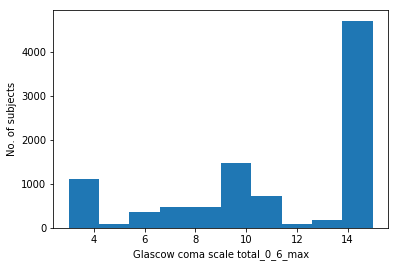

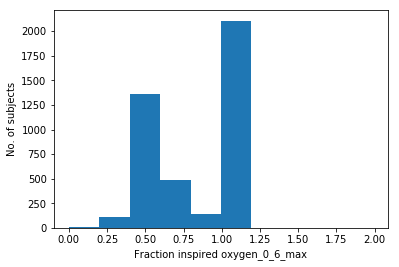

In [7]:
# Using visualizatino tool to explore data distribution
#
# For example, the following codes visuazized distritbution of features
# 'Glascow coma scale total_0_6_max' and 'Diastolic blood pressure_0_6_max'

import matplotlib.pyplot as plt

for var in ['Glascow coma scale total_0_6_max', 'Fraction inspired oxygen_0_6_max']:
    plt.hist(data[var], bins=10)
    plt.xlabel(var)
    plt.ylabel('No. of subjects')
    plt.show()

In [8]:
y = data['label'].values

X = data.drop(columns = ['Subj', 'label']).values

In [9]:
# Impute the missing values
from sklearn.impute import SimpleImputer

# if your sklearn version <= 0.20
# Do:
# from sklearn.preprocessing import Imputer
# imputer = Imputer(missing_values=np.nan, strategy='mean')

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer.fit(X)
X_imputed = np.array(imputer.transform(X), dtype=np.float32)


In [10]:
# Data scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 

scaler.fit(X_imputed)

X_imputed_scaled = scaler.transform(X_imputed)



In [11]:
X_imputed_scaled.shape

(17903, 672)

## Define the AutoEncoder

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_1, hidden_2, hidden):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_1),
            nn.Tanh(),
            nn.Linear(hidden_1, hidden_2),
            nn.Tanh(),
            nn.Linear(hidden_2, hidden),
            
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden, hidden_2),
            nn.Tanh(),
            nn.Linear(hidden_2, hidden_1),
            nn.Tanh(),
            nn.Linear(hidden_1, input_size),
#             nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded




In [13]:
autoencoder = AutoEncoder(input_size=672, hidden_1=128, hidden_2=64, hidden=16)

In [14]:
autoencoder

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=672, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=672, bias=True)
  )
)

## Model training

In [15]:
# Transform numpy data into tensor of pythorch
X_torch = torch.from_numpy(X_imputed_scaled).float()

In [16]:
X_torch

tensor([[-8.0267e-10, -1.9283e-02,  1.9122e+00,  ..., -1.4019e-03,
         -7.5413e-02,  1.7195e-01],
        [-8.0267e-10, -2.5877e-03, -5.6576e-08,  ..., -1.4019e-03,
         -3.4734e-11, -9.7246e-10],
        [-8.0267e-10, -2.1040e-02,  1.9122e+00,  ..., -1.4019e-03,
         -3.4734e-11, -9.7246e-10],
        ...,
        [-8.0267e-10,  8.8353e-03, -5.6576e-08,  ..., -1.4019e-03,
         -3.4734e-11, -9.7246e-10],
        [-8.0267e-10,  1.8501e-02, -5.6576e-08,  ..., -1.4019e-03,
         -3.4734e-11, -9.7246e-10],
        [-8.0267e-10,  1.1471e-02, -5.6576e-08,  ..., -1.4019e-03,
         -3.4734e-11, -9.7246e-10]])

In [17]:
X_torch.size()

torch.Size([17903, 672])

In [18]:
# Transform to torch dataset, to generate batches
import torch.utils.data as Data

batch_size = 32

data_set = Data.TensorDataset(X_torch)
    
# put data into DataLoader
loader = Data.DataLoader(
    dataset=data_set,           
    batch_size=batch_size,      # mini batch size
    shuffle=True,               # random?
    num_workers=2               # multithreading?
)

In [19]:
# Need to tune hyper-parameters
# Usually we need to try these parameters manually, here we use the emperical settings

num_epochs = 200
learning_rate = 0.001  # 0.01, 0.0002

In [20]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

loss_func = nn.MSELoss()

In [21]:
# Perform training
loss_list = []

for epoch in range(num_epochs):
    
    loss_temp = 0
    i = 0
    
    for step, b_x in enumerate(loader):
        i += 1
        
        b_x = b_x[0]

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_x)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        
        loss_temp += loss.data.numpy()
        
#         if step % 100 == 0:
#             print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())
    print("Epoch %s,  loss %.3f" % (epoch,  loss_temp/i))
    loss_list.append(loss_temp/i)     # loss recoder

Epoch 0,  loss 0.809
Epoch 1,  loss 0.757
Epoch 2,  loss 0.739
Epoch 3,  loss 0.725
Epoch 4,  loss 0.714
Epoch 5,  loss 0.707
Epoch 6,  loss 0.701
Epoch 7,  loss 0.694
Epoch 8,  loss 0.690
Epoch 9,  loss 0.685
Epoch 10,  loss 0.685
Epoch 11,  loss 0.684
Epoch 12,  loss 0.680
Epoch 13,  loss 0.675
Epoch 14,  loss 0.674
Epoch 15,  loss 0.671
Epoch 16,  loss 0.671
Epoch 17,  loss 0.665
Epoch 18,  loss 0.667
Epoch 19,  loss 0.673
Epoch 20,  loss 0.670
Epoch 21,  loss 0.660
Epoch 22,  loss 0.656
Epoch 23,  loss 0.656
Epoch 24,  loss 0.653
Epoch 25,  loss 0.653
Epoch 26,  loss 0.651
Epoch 27,  loss 0.648
Epoch 28,  loss 0.647
Epoch 29,  loss 0.647
Epoch 30,  loss 0.644
Epoch 31,  loss 0.641
Epoch 32,  loss 0.639
Epoch 33,  loss 0.637
Epoch 34,  loss 0.636
Epoch 35,  loss 0.634
Epoch 36,  loss 0.633
Epoch 37,  loss 0.637
Epoch 38,  loss 0.632
Epoch 39,  loss 0.626
Epoch 40,  loss 0.630
Epoch 41,  loss 0.624
Epoch 42,  loss 0.621
Epoch 43,  loss 0.622
Epoch 44,  loss 0.618
Epoch 45,  loss 0.61

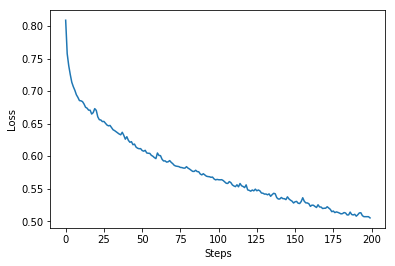

In [22]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

In [23]:
# use the trained model to get compressed features 
encoded_data, decoded_data = autoencoder(X_torch)

In [24]:
encoded_data.size()

torch.Size([17903, 16])

In [25]:
decoded_data.size()

torch.Size([17903, 672])

## Use the learned low-dimensional representaion vectors for data visualization

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, 
            init='random', # random ininitialization, other option: pca
            random_state=1)

X_encode_tsne = tsne.fit_transform(encoded_data.detach().numpy())

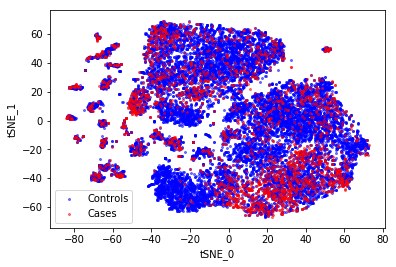

In [29]:
# Visualize training set with labels, based on t-SNE

plt.scatter(X_encode_tsne[y == 0, 0], X_encode_tsne[y == 0, 1], 
            s=4, # marker size
            c='blue', # color
            alpha=0.5, # transparency
            label='Controls', # label
           )
plt.scatter(X_encode_tsne[y == 1, 0], X_encode_tsne[y == 1, 1], 
            s=4, # marker size
            c='red', # color
            alpha=0.5, # transparency
            label='Cases', # label
           )


plt.xlabel('tSNE_0')
plt.ylabel('tSNE_1')

plt.legend() # show legend

plt.show()

## Use the learned representations for clustering analysis

Task: to identify sub-groups of patients who died in hospital

In [51]:
encoded_vecs = encoded_data.detach().numpy()

In [52]:
# Filtering: only using the patients died in hospital

encoded_vecs_death = encoded_vecs[y == 1]

In [53]:
encoded_vecs_death.shape

(2423, 16)

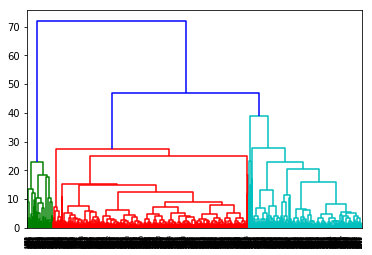

In [54]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
import scipy.spatial as sp


# Generate dendrogram to determine the optimal cluster number

linkage = shc.linkage(encoded_vecs_death,
                      method='ward', # options for method: average, single,
                                     #                     complete, ward, etc. 
                     )

den_plt = shc.dendrogram(linkage, orientation='top', color_threshold=45)

plt.show()



In [55]:
# According to the dendrogram, we determine the cluster number as 3

labels_hc = shc.fcluster(Z = linkage, # input linkage
                         t = 3, # cluster number
                         criterion = 'maxclust'
                        )

In [56]:
# Get the unique cluster labels

unique_labels, lanel_cnts = np.unique(labels_hc, return_counts=True)

In [57]:
# Visualize the identified sub-groups in TSNE space


from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, 
            init='random', # random ininitialization, other option: pca
            random_state=1)

X_death_encode_tsne = tsne.fit_transform(encoded_vecs_death)

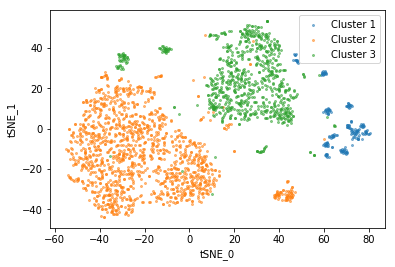

In [58]:
for l in unique_labels:
    plt.scatter(X_death_encode_tsne[labels_hc == l, 0], X_death_encode_tsne[labels_hc == l, 1], 
                s=4, # marker size
                alpha=0.5, # transparency
                label='Cluster %s' % l, # label
               )


plt.xlabel('tSNE_0')
plt.ylabel('tSNE_1')

plt.legend() # show legend

plt.show()